In [1]:
%load_ext autoreload 
%autoreload 2 

In [1]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf
import json

from src.data_processing.pipelines.LSTMPipe import LSTMPipe
from src.models.experimental_dropout_StackedLSTM import StackedLSTM




In [2]:
# print gpus available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
# MODEL_PATH = "/projects/p31961/ENIGMA/results/experiments/dopamine_full_sequence_stacked_lstm_01/models/dopamine_full_sequence_stacked_lstm_01"

# locald
DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
MODEL_PATH = '/Users/mds8301/Development/enigma/results/experiments/full_sequence_stacked_lstm_01/models/full_sequence_stacked_lstm_01'

In [5]:
processor = LSTMPipe(DATA_PATH)
processor.read_raw_data()
processor.raw_data=processor.raw_data[::10000]
processor.raw_data

,mouse_id,day,event,sensor,time,trial,signal,action,latency,sex,learning_phase,trial_count
0,12,5,cue,D2,-25.000000,0,-0.155359,escape,0.00,F,0,115
10000,12,5,cue,D2,12.614880,21,1.241920,avoid,0.00,F,2,136
20000,2,5,cue,D1,5.131291,15,1.258710,avoid,0.00,F,1,130
30000,9,5,escape,D2,-2.352298,5,0.212984,avoid,0.00,M,0,94
40000,2,5,avoid,D1,-9.835886,17,-0.925406,avoid,4.28,F,1,132
...,...,...,...,...,...,...,...,...,...,...,...,...
5820000,8,4,avoid,DA,-5.897155,5,-0.838271,avoid,3.77,M,0,88
5830000,8,4,cue,D2,-13.380744,1,-0.028153,avoid,0.00,M,0,84
5840000,8,4,cue,D2,-20.864332,23,0.290670,avoid,0.00,M,2,106
5850000,4,4,avoid,D1,16.750547,3,-0.066026,avoid,0.00,M,0,90


In [6]:
with open('/Users/mds8301/Development/enigma/results/experiments/full_sequence_stacked_lstm_01/subjects.json', 'r') as f:
    subjects = json.load(f)
subjects

{'training': [8, 3, 10, 13, 4, 1, 7, 6, 2], 'dev': [0, 11], 'test': [5, 9, 12]}

In [7]:
training_subjects = subjects['training']
dev_subjects = subjects['dev']
test_subjects = subjects['test']

training_query = ' or '.join([f"mouse_id=={subject}" for subject in training_subjects])
dev_query = ' or '.join([f"mouse_id=={subject}" for subject in dev_subjects])
test_query = ' or '.join([f"mouse_id=={subject}" for subject in test_subjects])

def split_by_subjects_query(subjects):
    query = ' or '.join([f"mouse_id=={subject}" for subject in subjects])
    x, y = processor.raw_data.query(query).drop(columns ="signal"), processor.raw_data.query(query)['signal']
    return x, y

processor.X_train, processor.y_train = split_by_subjects_query(training_subjects)
processor.X_dev, processor.y_dev = split_by_subjects_query(dev_subjects)
processor.X_test, processor.y_test = split_by_subjects_query(test_subjects)


In [8]:
# processor.transorm_data()
processor.X_train

,mouse_id,day,event,sensor,time,trial,action,latency,sex,learning_phase,trial_count
20000,2,5,cue,D1,5.131291,15,avoid,0.00,F,1,130
40000,2,5,avoid,D1,-9.835886,17,avoid,4.28,F,1,132
70000,1,5,cue,DA,12.811816,9,avoid,0.00,F,0,124
100000,1,5,avoid,DA,-9.638949,8,avoid,2.59,F,0,123
130000,13,5,cue,D2,13.008753,10,avoid,0.00,M,0,124
...,...,...,...,...,...,...,...,...,...,...,...
5820000,8,4,avoid,DA,-5.897155,5,avoid,3.77,M,0,88
5830000,8,4,cue,D2,-13.380744,1,avoid,0.00,M,0,84
5840000,8,4,cue,D2,-20.864332,23,avoid,0.00,M,2,106
5850000,4,4,avoid,D1,16.750547,3,avoid,0.00,M,0,90


2023-08-29 10:01:18.069553: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-08-29 10:01:18.069574: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-08-29 10:01:18.069580: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-08-29 10:01:18.069617: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-29 10:01:18.069632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


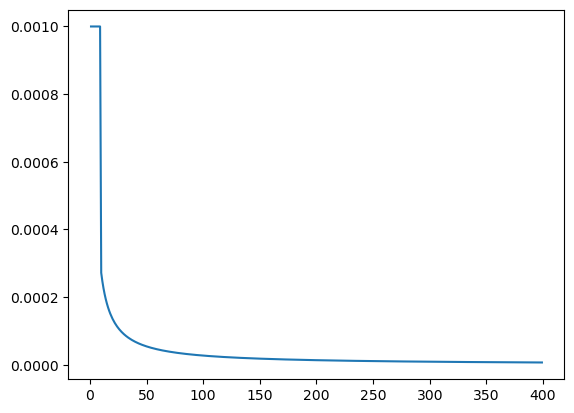

In [10]:
def lr_schedular(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(1.)/epoch
epochs = range(1,400,1)
lrs = np.array([lr_schedular(e, 0.001) for e in epochs])
plt.plot(epochs, lrs)
# plot loss



In [11]:
# tf tensor
X_train = tf.convert_to_tensor(processor.X_train)
y_train = tf.convert_to_tensor(processor.y_train)

In [13]:
X_train.shape[1]

18

In [9]:
model = StackedLSTM(
    sequence_length=processor.raw_data['time'].nunique(),
    num_features=processor.X_train.shape[1],
    lstm_units=processor.X_train.shape[1] * 2
)


model.compile(optimizer='adam', loss='mse', metrics=[
    'mae', 'mse', 'mape', 'cosine_similarity'])



# learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(
#     lr_schedular, verbose=1)

model.fit(processor.X_train,
            processor.y_train,
            epochs=5,
            validation_data=(processor.X_dev, processor.y_dev)
            )


2023-08-29 10:02:30.284302: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-08-29 10:02:30.284324: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2023-08-29 10:02:30.284329: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2023-08-29 10:02:30.284377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-29 10:02:30.284397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH)

# model.compile(optimizer='adam', loss='mse', metrics=[
#         'mae', 'mse', 'mape', 'cosine_similarity'])

In [ ]:
model.summary()

In [ ]:
x_test_raw, y_test_raw = split_by_subjects_query(test_subjects)
full_test_set = (x_test_raw
                 .assign(
                     true_signal=y_test_raw,
                     predicted_signal = predicted_signal
                     )
                 )


In [ ]:
full_test_set.shape

In [ ]:
full_test_set.isnull().sum()

In [ ]:
full_test_set

In [ ]:

processor_pipe = (LSTMPipe(DATA_PATH)
.read_raw_data(sort_by=['mouse_id','sensor','event', 'trial_count']))
processor.raw_data = processor_pipe.raw_data[::10000]
(processor_pipe.split_data(processed_data = False, 
            test_size=0.3,
            test_dev_size=0.5, 
            split_group = "mouse_id", 
            stratify_group = "sex", 
            target='signal', 
            save_subject_ids=False)
.transorm_data()
)

In [ ]:
from src.models.experimental_dropout_StackedLSTM import StackedLSTM
def lr_schedular(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)


model = StackedLSTM(
    sequence_length=processor.raw_data['time'].nunique(),
    num_features=processor.X_train.shape[1],
    lstm_units=processor.X_train.shape[1] * 2
)


model.compile(optimizer='adam', loss='mse', metrics=[
    'mae', 'mse', 'mape', 'cosine_similarity'])

# call backs


learning_rate_callback = tf.keras.callbacks.LearningRateScheduler(
    lr_schedular, verbose=1)

model.fit(processor.X_train,
            processor.y_train,
            epochs=5,
            validation_data=(processor.X_dev, processor.y_dev),
            callbacks=[learning_rate_callback]
            )


model.evaluate(processor.X_test, processor.y_test)





In [ ]:
sns.lineplot(data = avoid, x = 'time', y = 'signal', hue = 'signal_type')
# sns.lineplot(data = query, x = 'time', y = 'predicted_signal')

In [ ]:
facet = sns.FacetGrid(avoid, row = 'day', col = "learning_phase")
facet.map_dataframe(sns.lineplot, x = 'time', y = 'signal', hue = 'signal_type', hue_order = ["true_signal", "predicted_signal"])

In [ ]:
mouse_3 = avoid.query("mouse_id_3==1 & trial_count < 10")
mouse_3

In [ ]:
sns.lineplot(data = mouse_3.query("trial_count==9"), x = 'time', y = 'signal', hue = 'signal_type')

In [ ]:
evalulation = model.evaluate(X_test, y_test)
for name, value in zip(model.metrics_names, evalulation):
    print(f'{name}: {value}')

## Analysis on training set

In [ ]:
def query_testing_subjects(subjects, df):
    
    full_query = ''
    for mouse in subjects:
        query =f"{mouse} == 1"
        if full_query == '':
            full_query = query
        else:
            full_query += f" or {query}" 
        
    return df.query(full_query)

train_set = query_testing_subjects(subjects_by_category['training'], train_processor.data)
X_train, y_train = train_set.drop(columns = 'signal'), train_set['signal']

In [ ]:
predicted_signal = model.predict(X_train)

In [ ]:
full_train_set = (X_train
                 .assign(
                     true_signal=y_train,
                     predicted_signal = predicted_signal
                     )
                 )

In [ ]:
train_avoid = (full_train_set
         .query("action_avoid==1 & event_cue==1")
         .melt(id_vars = full_test_set.drop(columns = ['predicted_signal', 'true_signal']).columns, value_vars= ['predicted_signal', 'true_signal'], value_name = "signal", var_name = 'signal_type'))
train_avoid

In [ ]:
sns.lineplot(data = train_avoid, x = 'time', y = 'signal', hue = 'signal_type')

In [ ]:
facet = sns.FacetGrid(train_avoid, row = 'day', col = "learning_phase")
facet.map_dataframe(sns.lineplot, x = 'time', y = 'signal', hue = 'signal_type', hue_order = ["true_signal", "predicted_signal"])

In [ ]:
mouse_id_1_train  = train_avoid.query("mouse_id_1==1 & trial_count < 20")
sns.lineplot(data = mouse_id_1_train.query("trial_count==17"), x = 'time', y = 'signal', hue = 'signal_type')

# Summary
given the training performance data, I think this model is still overrfitting. It looks a little better, but validation loss is still increasing. I am going to expand on this and include a standard learning rate schedular in experiment 3
